<a href="https://colab.research.google.com/github/Ragdehl/Rakuten_py/blob/main/manu/TestXcept190721.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout,Dense, Flatten, GlobalAveragePooling2D
from keras import layers
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.optimizers import SGD
from keras.applications.xception import Xception, preprocess_input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.applications as kapps
from keras import backend as k
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import callbacks

In [2]:
X = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TRAINING DATASCIENTEST/PROJET DATASCIENTEST/Archivage datas projets RAKUTEN/X_train_update.csv',index_col=0)
y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TRAINING DATASCIENTEST/PROJET DATASCIENTEST/Archivage datas projets RAKUTEN/Y_train_CVw08PX.csv',index_col=0)

In [ ]:
#Create a column with the name of the picture
X['image name'] = 'image_' + X['imageid'].map(str) + '_product_' + X['productid'].map(str) + '.jpg'

In [5]:
# current_path = os.getcwd() 
#images_path = current_path + r'/images2/image_train/'
path ='/content/drive/MyDrive/Colab Notebooks/TRAINING DATASCIENTEST/PROJET DATASCIENTEST/Archivage datas projets RAKUTEN/images tests/image_train'

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 123)
X_val = X_train.iloc[:8400,:]
y_val = y_train.iloc[:8400,:]
X_train = X_train.iloc[8401:84000,:]
y_train = y_train.iloc[8401:84000:,:]
X_test = X_test.iloc[:13800,:]
y_test = y_test.iloc[:13800,:]

X_train["class"] = y_train
X_test["class"] = y_test
X_val["class"] = y_val

In [11]:
train_data_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range = 0.15, height_shift_range = 0.15,zoom_range = 1.1, horizontal_flip = True)
val_data_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range = 0.15, height_shift_range = 0.15,zoom_range = 1.1,horizontal_flip = True)
test_data_generator = ImageDataGenerator(rescale = 1./255)

In [12]:
batch_size = 64
path = images_path
X_train["class"] = X_train["class"].astype(str)
X_test["class"] = X_test["class"].astype(str)
X_val["class"] = X_val["class"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe=X_train, directory=path, x_col = "image name", y_col = "class",
class_mode ="sparse", target_size = (240, 240), batch_size = batch_size)

val_generator = val_data_generator.flow_from_dataframe(dataframe=X_val, directory=path, x_col = "image name", y_col = "class",
class_mode ="sparse", target_size = (240, 240), batch_size = batch_size)

test_generator = test_data_generator.flow_from_dataframe(dataframe=X_test, directory=path, x_col = "image name", y_col = "class",
class_mode ="sparse", target_size = (240, 240), batch_size = batch_size)

Found 52737 validated image filenames belonging to 27 classes.
Found 8400 validated image filenames belonging to 27 classes.
Found 13800 validated image filenames belonging to 27 classes.


In [15]:
basemodel = kapps.xception.Xception( input_shape = (240, 240, 3) ,include_top = False, weights = 'imagenet')
# Freezer les couches
basemodel = basemodel
for layer in basemodel.layers:
    layer.trainable = False 

basemodel.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 119, 119, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 119, 119, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 119, 119, 32) 0           block1_conv1_bn[0][0]            
__________________________

In [18]:
x = layers.Flatten()(basemodel.output)
x = layers.Dense(1024, activation='swish')(x)
x = Dropout(0.35)(x)
x = Dense(512, activation='swish')(x)
x = layers.Dropout(0.30)(x)
x = Dense(256, activation='swish')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(27, activation='softmax')(x)
opt = Adam(lr=0.0001)
model = tf.keras.models.Model(basemodel.input, x)
model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
epoch = 10
test_history19 = model.fit(train_generator, epochs = epoch,steps_per_epoch = len(X_train)//batch_size, validation_data = val_generator,
                        validation_steps = len(X_val)//batch_size) 

Epoch 1/10
824/824 [==============================] - 24193s 29s/step - loss: 2.2820 - acc: 0.3395 - val_loss: 2.1566 - val_acc: 0.3720
Epoch 2/10
824/824 [==============================] - 1120s 1s/step - loss: 2.0965 - acc: 0.3865 - val_loss: 2.0470 - val_acc: 0.3927
Epoch 3/10
824/824 [==============================] - 1110s 1s/step - loss: 2.0278 - acc: 0.4021 - val_loss: 2.0182 - val_acc: 0.4060
Epoch 4/10
824/824 [==============================] - 1106s 1s/step - loss: 1.9926 - acc: 0.4130 - val_loss: 1.9744 - val_acc: 0.4138
Epoch 5/10
824/824 [==============================] - 1118s 1s/step - loss: 1.9477 - acc: 0.4245 - val_loss: 1.9699 - val_acc: 0.4188
Epoch 6/10
824/824 [==============================] - 1135s 1s/step - loss: 1.9264 - acc: 0.4295 - val_loss: 1.9859 - val_acc: 0.4226
Epoch 7/10
824/824 [==============================] - 1100s 1s/step - loss: 1.8947 - acc: 0.4368 - val_loss: 1.9543 - val_acc: 0.4330
Epoch 8/10
824/824 [==============================] - 1098s 

In [20]:
for layer in basemodel.layers[-4:]:
    layer.trainable = True

In [21]:
model.compile(optimizer= opt , loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
hist_unfreeze19 = model.fit(train_generator, epochs = 10, steps_per_epoch = len(X_train)//batch_size, validation_data=test_generator,
                                validation_steps=len(X_val)//batch_size)

Epoch 1/10
824/824 [==============================] - 4283s 5s/step - loss: 1.8656 - accuracy: 0.4462 - val_loss: 1.4390 - val_accuracy: 0.5747
Epoch 2/10
824/824 [==============================] - 2268s 3s/step - loss: 1.7840 - accuracy: 0.4688 - val_loss: 1.4267 - val_accuracy: 0.5707
Epoch 3/10
824/824 [==============================] - 1503s 2s/step - loss: 1.7479 - accuracy: 0.4778 - val_loss: 1.4217 - val_accuracy: 0.5718
Epoch 4/10
824/824 [==============================] - 1173s 1s/step - loss: 1.7220 - accuracy: 0.4845 - val_loss: 1.4271 - val_accuracy: 0.5786
Epoch 5/10
824/824 [==============================] - 1081s 1s/step - loss: 1.6941 - accuracy: 0.4943 - val_loss: 1.3575 - val_accuracy: 0.5868
Epoch 6/10
824/824 [==============================] - 1049s 1s/step - loss: 1.6656 - accuracy: 0.5007 - val_loss: 1.3807 - val_accuracy: 0.5810
Epoch 7/10
824/824 [==============================] - 1043s 1s/step - loss: 1.6463 - accuracy: 0.5075 - val_loss: 1.3666 - val_accuracy:

In [ ]:
model.evaluate...

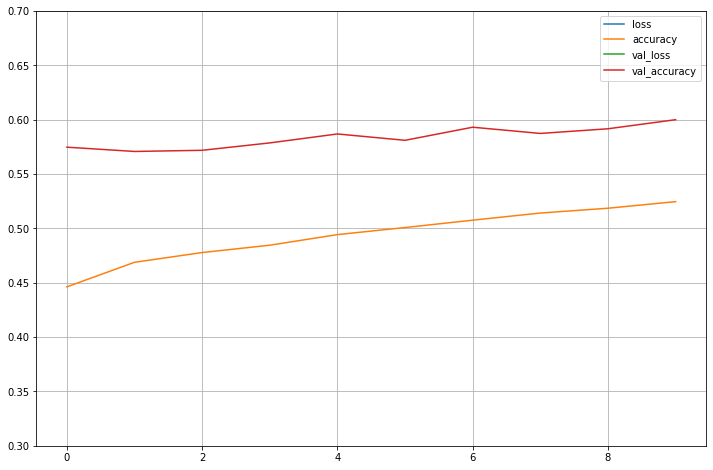

In [25]:
import pandas as pd
pd.DataFrame(hist_unfreeze19.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0.3, 0.7) 
plt.show()

In [26]:
y_pred19 = model.predict_generator(test_generator, verbose = 1)
y_pred19 = y_pred19.argmax(axis = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


216/216 [==============================] - 94s 432ms/step


# The Xception architecture

We propose a convolutional neural network architecture
based entirely on depthwise separable convolution layers.
In effect, we make the following hypothesis: that the mapping of cross-channels correlations and spatial correlations
in the feature maps of convolutional neural networks can be
entirely decoupled. Because this hypothesis is a stronger version of the hypothesis underlying the Inception architecture,
we name our proposed architecture Xception, which stands
for “Extreme Inception”.
